### In this project, we would explore regression analysis and make predictions on used car prices. After that, we would build a web app for user interactions and live predictions.
---
1. *In Part I of the project we pre-processed the data*
2. #### This is PART II of the project where we focus on using regression method for used car prices prediction

#### Highlights of this part:
1.  Regression method - RandomForestRegressor
2.  Building pipelines
3.  Regression performance evaluation and improvements

**Citations:**

This dataset is from Kaggle - Used Cars Dataset

URL: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

---

The following description is from Kaggle:

**Context**

Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist.

**Content**

This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories. For ML projects, consider feature engineering on location columns such as long/lat. For previous listings, check older versions of the dataset.

See https://github.com/AustinReese1998/craigslistFilter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load dataset generated from Part I
df = pd.read_csv('Data/vehicles_pre-processed.csv')

#### Here we would draw a sample of 100000 from the dataframe to decrease the processing time. After model performance evaluations and improvements, we can retrain the model on the entire dataset.

In [3]:
df_original = df.copy()
df = df.sample(100000)
df.reset_index(drop = True, inplace = True)

In [4]:
df.head()

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state
0,5995,2011.0,chevrolet,traverse,gas,149453.0,clean,automatic,la
1,15000,2015.0,mazda,Others,gas,44000.0,clean,automatic,hi
2,7500,2012.0,honda,civic,diesel,166000.0,clean,automatic,ar
3,13500,2004.0,ford,f-250,gas,81717.0,clean,automatic,nj
4,16990,2015.0,ford,f-250,other,202615.0,clean,automatic,fl


We could do some visualizations on the data, for example the following. I would create another demonstration solely on data visualizations. For now, let's focus on the objective of predicting used car prices.

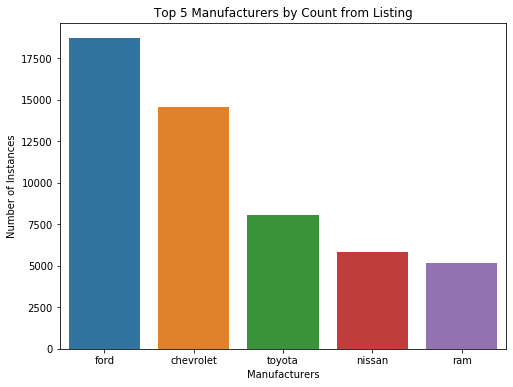

In [5]:
mc = df['manufacturer'].value_counts().head()
plt.figure(figsize = (8, 6))
sns.barplot(x = mc.index, y = mc.values)
plt.title('Top 5 Manufacturers by Count from Listing')
plt.xlabel('Manufacturers')
plt.ylabel('Number of Instances')
plt.show()

#### Before we fit the data using regression models, we would like to standardize the numerical features and one-hot encode the categorical features. For detailed explanations on the methods, please refer to the Portfolio Project 1: Predictive Analysis Structure - Hotel Booking Classification

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
#Build Feature_Selector class
class FeatureSelector(BaseEstimator, TransformerMixin):
    '''
    Select certain features from a Dataframe, return numpy array
    '''
    def __init__(self, columns):
        '''
        columns: list of columns
        '''
        self.columns = columns
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X.loc[:, self.columns].values.reshape(-1, len(self.columns))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         100000 non-null  int64  
 1   year          100000 non-null  float64
 2   manufacturer  100000 non-null  object 
 3   model         100000 non-null  object 
 4   fuel          100000 non-null  object 
 5   odometer      100000 non-null  float64
 6   title_status  100000 non-null  object 
 7   transmission  100000 non-null  object 
 8   state         100000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.9+ MB


In [9]:
#StandardScaler and OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Build Transformer Pipelines
from sklearn.pipeline import make_pipeline, make_union

cat_fs = FeatureSelector(['manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state'])
num_fs = FeatureSelector(['year', 'odometer']) # We treat year column as numeric

cat_trans = make_pipeline(cat_fs, OneHotEncoder(drop = 'first', sparse = False))
num_trans = make_pipeline(num_fs, StandardScaler())

union_trans = make_union(cat_trans, num_trans)

#### We would start from fitting a Random Forest Regression model. Again, all details on reasons behind each individual steps could be found in Portfolio Project 1: Predictive Analysis Structure - Hotel Booking Classification

In [10]:
X = df.drop(['price'], axis = 1)
y = df['price'].values

In [11]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size = 0.1)

In [12]:
#Further split train_all into training and cross validation sets since we do not want to touch the test set yet
X_train, X_cv, y_train, y_cv = train_test_split(X_train_all, y_train_all, test_size = 0.1)

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs = -1)
forest_pipe = make_pipeline(union_trans, forest)

In [14]:
#Now fit the data and make predictions
forest_pipe.fit(X_train, y_train)
pred_cv = forest_pipe.predict(X_cv)

#### *Note that the available selections of car models should be dependent upon the manufacturers. However, here for simplicity, we did not model the relationship directly - ex. merging manufacturers and car models columns to be one column*

#### Now we can evaluate the model performance, for performance evaluation for regression, we could use the following methods:
1. Residual plot
2. Mean squared error (MSE)
3. R-squared

Text(0.5, 1.0, 'Residual Plot')

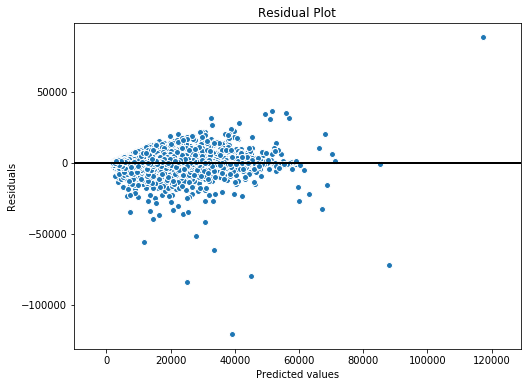

In [15]:
#Residual plot
plt.figure(figsize = (8, 6))
plt.scatter(pred_cv, pred_cv - y_cv, edgecolor = 'white')
plt.hlines(y = 0, xmin = -10000, xmax = pred_cv.max() * 1.1, color = 'black', lw = 2)
plt.xlim(-10000, pred_cv.max() * 1.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

#### As we can see, although our model is ok in general, there are still rooms for improvement - first, the resuduals are not entirely randomly distributed, which means there are patterns not caught by our model. Second, there are some significant outliers which might have impacted the model performance. But before we move on to how we can improve this model, let's quickly check the other performance evaluation metrics.

In [16]:
#MSE
mse = np.mean((y_cv - pred_cv)**2)
print(f'The MSE is {round(mse, 3)}.')

The MSE is 23791558.31.


#### It is hard to evaluate the mean squared error metric unless we compare with the ones from other models. Thus, we can look at R-squared, which tells us how much of the variation in the response variable the model has captured.

In [17]:
from sklearn.metrics import r2_score
print(f'The R^2 score is {round(r2_score(y_cv, pred_cv), 3)}')

The R^2 score is 0.793


#### So just based on the R-squared score, our model did not do that bad...
#### Next, we would focus on how to improve model performance. Usually, we first have to find out if the model is suffering from high bias or high variance before we determine our next steps - and the method to do that is to plot the learning curve (see Portfolio Project 1 on plotting learning curve). However, here first of all because we have lots of data to work with, the variance should be reduced by some level. In addtion, because we are using Random Forest Algorithm (an ensemble method), variance would be further reduced. So what we really want to do here is to tackle the bias problem. We could use the following methods:
1. Add additional features (e.g. feature engineering, adding polynomial features)
2. Use a more complex model
3. Tune Hyperparameters (might be related to #1 and/or #2 depending on situations)

#### In this demostration, we would focus on methods #1 and #3 above.

#### First, we would try to add some polynomial features to introduce additional nonlinearity in the model training in order to reduce bias.

In [18]:
#We would change the numerical pipeline
from sklearn.preprocessing import PolynomialFeatures
num_trans_poly = make_pipeline(num_fs, PolynomialFeatures(degree = 3), StandardScaler())
union_trans_poly = make_union(cat_trans, num_trans_poly)

forest_pipe_poly = make_pipeline(union_trans_poly, forest)

#Now fit the data and make predictions
forest_pipe_poly.fit(X_train, y_train)
pred_cv_poly = forest_pipe_poly.predict(X_cv)

In [19]:
print(f'The MSE score after adding polynomial terms is {round(np.mean((y_cv - pred_cv_poly)**2), 3)}')
print(f'The R^2 score after adding polynomial terms is {round(r2_score(y_cv, pred_cv_poly), 3)}')

The MSE score after adding polynomial terms is 23437374.061
The R^2 score after adding polynomial terms is 0.796


#### Unfortunately, adding polynomial terms does not seem to improve model performance

#### Finally, let's use RandomizedSearchCV method to tune model hyperparameters. Comparing to Grid Search, Randomized Search could take less time while still finding relatively good model hyperparameters combinations.

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import scipy.stats as stats

scorer = make_scorer(r2_score)
param_dist = {'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
             'randomforestregressor__max_depth': [25, 50, 100, None],
             'randomforestregressor__max_samples': stats.uniform(0, 1),
              'randomforestregressor__n_estimators': [25, 50, 100, 150]
             }

rs = RandomizedSearchCV(estimator = forest_pipe, param_distributions = param_dist, 
                       n_iter = 20, scoring = scorer, n_jobs = -1, cv = 5)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('featureunion',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('pipeline-1',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('featureselector',
                                                                                               FeatureSelector(columns=['manufacturer',
                                                                                                                        'model',
                                                                                                                        'fuel',
                                                                          

In [21]:
print(f'The best hyperparameter combination is: {rs.best_params_}.')

The best hyperparameter combination is: {'randomforestregressor__max_depth': 100, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_samples': 0.9439543587792775, 'randomforestregressor__n_estimators': 100}.


Text(0.5, 1.0, 'Residual Plot')

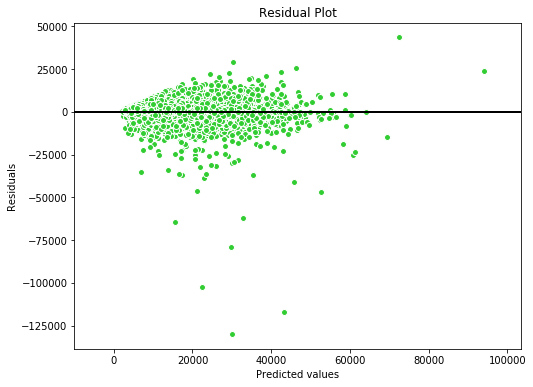

In [22]:
pred_cv = rs.predict(X_cv)

#Residual plot
plt.figure(figsize = (8, 6))
plt.scatter(pred_cv, pred_cv - y_cv, c = 'limegreen', edgecolor = 'white')
plt.hlines(y = 0, xmin = -10000, xmax = pred_cv.max() * 1.1, color = 'black', lw = 2)
plt.xlim(-10000, pred_cv.max() * 1.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

In [23]:
print(f'The MSE score after finding the best hyperparameter combination using RandomizedSearchCV is {round(np.mean((y_cv - pred_cv)**2), 3)}.')
print(f'The R^2 score after finding the best hyperparameter combination using RandomizedSearchCV is {round(r2_score(y_cv, pred_cv), 3)}.')

The MSE score after finding the best hyperparameter combination using RandomizedSearchCV is 23971487.002.
The R^2 score after finding the best hyperparameter combination using RandomizedSearchCV is 0.791.


#### Again, there is no significant performance changes using RandomizedSearchCV. Anyway, let's finally use our test set to perform one last performance evaluation.

In [24]:
pred_test = rs.predict(X_test)

Text(0.5, 1.0, 'Residual Plot')

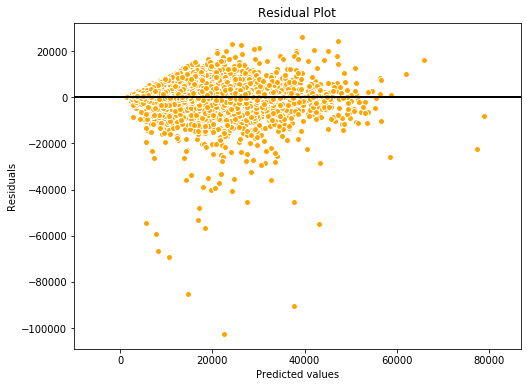

In [25]:
#Residual plot
plt.figure(figsize = (8, 6))
plt.scatter(pred_test, pred_test - y_test, c = 'orange', edgecolor = 'white')
plt.hlines(y = 0, xmin = -10000, xmax = pred_test.max() * 1.1, color = 'black', lw = 2)
plt.xlim(-10000, pred_test.max() * 1.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

#### The residual plot for the test set looks as good as the previous one from the cv set, that means we should have low variance, we can confirm it using R-squared score.

In [26]:
print(f'The R^2 score for test set is {round(r2_score(y_test, pred_test), 3)}.')

The R^2 score for test set is 0.799.


#### So indeed we have low variance here, unfortunately we are not able to improve performance much by tackling bias. Although not demonstrated here, we might be able to reduce bias by gathering more meaningful features or try more complex models, although that in turn might increase the computational complexity.
#### Before we wrap up, remember that until now we only used a subset of all the data for analysis, so here we would like to use the model we got from RandomizedSearchCV to fit all the data we have.

In [27]:
X_original = df_original.drop(['price'], axis = 1)
y_original = df_original['price'].values

In [28]:
best_estimator = rs.best_estimator_

In [29]:
best_estimator.fit(X_original, y_original)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('featureselector',
                                                                  FeatureSelector(columns=['manufacturer',
                                                                                           'model',
                                                                                           'fuel',
                                                                                           'title_status',
                                                                                           'transmission',
                                                                                           'state'])),
                                                            

#### We can quickly check on the R-squared score.

In [30]:
print(f'The R^2 score for fitting and predicting on the entire data available \
is {round(r2_score(y_original, best_estimator.predict(X_original)), 3)}.')

The R^2 score for fitting and predicting on the entire data available is 0.973.


Below is an example of using our best_estimator to predict used car prices

In [31]:
X_ex = pd.DataFrame({'year': [2012], 'manufacturer': ['honda'], 'model': ['civic'], 
                    'fuel': ['gas'], 'odometer': [75000], 'title_status': ['clean'],
                    'transmission': ['automatic'], 'state': ['il']})
X_ex

,year,manufacturer,model,fuel,odometer,title_status,transmission,state
0,2012,honda,civic,gas,75000,clean,automatic,il


In [32]:
print(f'The predicted price of this used 2012 honda civic is {best_estimator.predict(X_ex)[0]}.')

The predicted price of this used 2012 honda civic is 8278.77.


We can compare the predicted price we got with prices from online sources, the following is from Kelly Blue Book (https://www.kbb.com/) as of 3/31/2020
<img src = "Img/2012 Honda Civic Kbb Price.png" width="600">

#### The last step is to store our trained best_estimator in a joblib file so that we can use it directly in our Web App, which we would develop next.

In [33]:
from joblib import dump
import os

folder = 'Web App\\Joblib_objects'
if not os.path.exists(folder):
    os.makedirs(folder)
    
dump(best_estimator, os.path.join(folder, 'best_estimator.joblib'))

['Web App\\Joblib_objects\\best_estimator.joblib']

#### All Set!